In [1]:
### Dependencies

from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os
import re
import time

In [2]:
## Start timer
start_time = time.time()



### This notebook is for extracting the data from the original kml file and outputing a JSON that will be easy to use with Google Maps API



In [3]:
## LOAD BLOCK###
#### Load data from kml file exported from Google Earth

file_path = ('data/kml/ballparks.kml') # file path to kml file

with open(file_path) as file:

    xml_data = file.read()



# Initialize soup variables for parsing file
soup = BeautifulSoup(xml_data, 'xml')
folders = soup.Document.Folder
list = soup.Document.Folder.find_all('Folder')

## Create a dataframe to hold the data parsed from xml
df = pd.DataFrame(columns=['field', 'foul', 'fop'])

failed = []


In [4]:
#### EXTRACTION BLOCK ####
#### Extract data from kml file

# Create an empty list to store the rows to append to the DataFrame
rows = []

# Loop through the folders and extract the data
for folder in list:
    try:
        field_name = folder.find('name').text
        foul = folder.find_all('coordinates')[0].text
        fop = folder.find_all('coordinates')[1].text

        row = {
            'field': field_name,
            'foul': foul,
            'fop': fop
        }

        rows.append(row)

    except Exception as e:
        # Add name of folder to a list of failed folders
        failed.append(folder.find('name').text)
        print(f"Error processing folder: {folder.find('name').text}. Error message: {str(e)}")

# Convert the list of rows to a DataFrame
df = pd.DataFrame(rows)

# Print a list of failed folders
print(f"Failed to process {len(failed)} folders: {', '.join(failed)}")


Error processing folder: Progressive Field - Cleveland - MLB. Error message: list index out of range
Failed to process 1 folders: Progressive Field - Cleveland - MLB


In [5]:
# Define a dictionary that maps level indicators to levels and size factors
level_dict = {
    'International': 'international',
    'Major Leagues': 'mlb', 
    'Professional': 'pro', 
    'College': 'college', 
    'High School': 'high_school',
    'Youth': 'youth',
    
}

In [6]:
# Create a copy of the original DataFrame
df_cleaned = df.copy()

# Remove new line and space characters from coordinates
df_cleaned = df_cleaned.replace(r'\n','', regex=True) 
df_cleaned = df_cleaned.replace(r'\t','', regex=True) 

# Drop any duplicate rows
df_cleaned = df_cleaned.drop_duplicates(subset=['field'], keep='first')

# Drop any rows with empty fields
df_cleaned = df_cleaned[(df_cleaned != 0).all(1)]

# Define the regex patterns for each level
re_mlb = re.compile(r'mlb', re.IGNORECASE)
re_pro = re.compile(r'pro|semi[-\s]*pro', re.IGNORECASE)
re_college = re.compile(r'college', re.IGNORECASE)
re_high_school = re.compile(r'high school|hs', re.IGNORECASE)  # Include the abbreviation 'hs'
re_youth = re.compile(r'youth', re.IGNORECASE)
re_muni = re.compile(r'muni', re.IGNORECASE)
re_international = re.compile(r'international', re.IGNORECASE)

# Define a function to classify the fields based on the regex patterns
def classify_field(field_name):
    if re_mlb.search(field_name):
        return 'Major League'
    elif re_pro.search(field_name):
        return 'Professional'
    elif re_college.search(field_name):
        return 'College'
    elif re_high_school.search(field_name):
        return 'High School'
    elif re_youth.search(field_name):
        return 'Youth'
    elif re_muni.search(field_name):
        return 'State / County / Municipal'
    elif re_international.search(field_name):
        return 'International'
    else:
        return 'Unknown'

# Apply the classify_field function to the 'field' column
df_cleaned['level'] = df_cleaned['field'].apply(classify_field)

# Clean up the 'field' column by removing the level indicator and any trailing '-' characters
level_regex = r'\s*(%s)\s*' % '|'.join(re.escape(level) for level in level_dict.values())
df_cleaned['field'] = df_cleaned['field'].str.replace(level_regex, '', regex=True, flags=re.IGNORECASE)
df_cleaned['field'] = df_cleaned['field'].str.replace(r'-\s*$', '', regex=True)

# Rename field column to park_name to avoid confusion down the line
df_cleaned = df_cleaned.rename(columns={'field': 'park_name'})



In [7]:
df_cleaned.head()

## print a list of all the values in the level column
# print(df_cleaned['level'].unique())

## Print the two the headers and two rows of data to a txt file for reference


# with open('data/rows.txt', 'w') as f:
#     f.write(df_cleaned.iloc[0].to_string())
#     f.write(df_cleaned.iloc[1].to_string())
#     f.write(df_cleaned.iloc[14].to_string())
    

# print(df_cleaned.iloc[15].to_string())


,park_name,foul,fop,level
0,Day Air Ballpark - Dayton Dragons,"-84.18557,39.7642091,0 -84.18494440000001,39.7...","-84.18557,39.7642091,0 -84.18460640000001,39.7...",Professional
1,Parkview Field - Fort Wayne TinCaps,"-85.14299819999999,41.0741133,0 -85.1432207999...","-85.14299819999999,41.0741133,0 -85.1418776999...",Professional
2,Classic Park- Lake County Captains,"-81.43620009999999,41.6407581,0 -81.4362007999...","-81.43620009999999,41.6407581,0 -81.4350347,41...",Professional
3,ABC Supply Stadium - Beloit Sky Carp,"-89.0406651,42.4971349,0 -89.0408006,42.498079...","-89.0406651,42.4971349,0 -89.03947290000001,42...",Professional
4,Veterans Memorial Stadium - Cedar Rapids Kernels,"-91.6867962,41.9677456,0 -91.68678009999999,41...","-91.6867962,41.9677456,0 -91.6856006,41.967735...",Professional


In [8]:
##### Clean up polygon data and create a new home_plate column

def parse_coordinates(coord_string):
    coords = coord_string.split()
    parsed_coords = [tuple(map(float, coord.split(',')[:2])) for coord in coords]
    return parsed_coords

# Create a new column for the home_plate location using the first set of coordinates in the 'fop' column
df_cleaned['home_plate'] = df_cleaned['fop'].apply(lambda x: parse_coordinates(x)[0])

# Apply the parse_coordinates function to the 'foul' and 'fop' columns
df_cleaned['foul'] = df_cleaned['foul'].apply(parse_coordinates)
df_cleaned['fop'] = df_cleaned['fop'].apply(parse_coordinates)


In [9]:
## Doesn't seem to be returning useful data - will need to revisit

# def determine_direction(coordinates):
#     num_points = len(coordinates)
#     if num_points < 2:
#         return "Not enough points"

#     # Get the latitude (y-coordinate) values
#     latitudes = [point[1] for point in coordinates]

#     # Check the change in latitude values
#     increasing_latitudes = all(latitudes[i] <= latitudes[i+1] for i in range(num_points-1))
#     decreasing_latitudes = all(latitudes[i] >= latitudes[i+1] for i in range(num_points-1))

#     if increasing_latitudes:
#         return "Left Field"
#     elif decreasing_latitudes:
#         return "Right Field"
#     else:
#         return "Collinear"

# # Apply the determine_direction function to the 'fop' and 'foul' columns
# df_cleaned['fop_direction'] = df_cleaned['fop'].apply(determine_direction)
# df_cleaned['foul_direction'] = df_cleaned['foul'].apply(determine_direction)

# # Print the updated DataFrame
# print(df_cleaned)



In [10]:
df_cleaned.head()

## Value counts for the fop_direction column
df_cleaned['level'].value_counts()

## Value counts for the foul_direction column
# df_cleaned['foul_direction'].value_counts()

df_cleaned.head()




,park_name,foul,fop,level,home_plate
0,Day Air Ballpark - Dayton Dragons,"[(-84.18557, 39.7642091), (-84.1849444, 39.764...","[(-84.18557, 39.7642091), (-84.1846064, 39.763...",Professional,"(-84.18557, 39.7642091)"
1,Parkview Field - Fort Wayne TinCaps,"[(-85.1429982, 41.0741133), (-85.1432208, 41.0...","[(-85.1429982, 41.0741133), (-85.1418777, 41.0...",Professional,"(-85.1429982, 41.0741133)"
2,Classic Park- Lake County Captains,"[(-81.4362001, 41.6407581), (-81.4362008, 41.6...","[(-81.4362001, 41.6407581), (-81.4350347, 41.6...",Professional,"(-81.4362001, 41.6407581)"
3,ABC Supply Stadium - Beloit Sky Carp,"[(-89.0406651, 42.4971349), (-89.0408006, 42.4...","[(-89.0406651, 42.4971349), (-89.0394729, 42.4...",Professional,"(-89.0406651, 42.4971349)"
4,Veterans Memorial Stadium - Cedar Rapids Kernels,"[(-91.6867962, 41.9677456), (-91.6867801, 41.9...","[(-91.6867962, 41.9677456), (-91.6856006, 41.9...",Professional,"(-91.6867962, 41.9677456)"


In [11]:
import pyproj
from shapely.geometry import Polygon
from shapely.ops import transform


def calculate_area(coords):
    # Create a Polygon object from the coordinates
    polygon = Polygon(coords)

    # Calculate the centroid of the polygon
    centroid = polygon.centroid

    # Create a custom LAEA projection centered on the centroid
    custom_projection = f"+proj=laea +lat_0={centroid.y} +lon_0={centroid.x} +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

    # Create a transformer for converting coordinates to the custom LAEA projection
    transformer = pyproj.Transformer.from_crs(
        pyproj.CRS("EPSG:4326"),  # WGS 84 (latitude and longitude)
        pyproj.CRS(custom_projection),  # Custom LAEA projection
        always_xy=True
    )

    # Define a function to transform coordinates using the transformer
    def transform_coordinates(x, y):
        return transformer.transform(x, y)

    # Convert the coordinates to the custom LAEA projection
    polygon_laea = transform(transform_coordinates, polygon)

    # Calculate the area in square meters
    area_sqm = polygon_laea.area

    # Convert the area to square feet (1 square meter = 10.764 square feet)
    area_sqft = area_sqm * 10.764

    return area_sqft



### Call Function and add to dataframe
df_cleaned['foul_area_sqft'] = df_cleaned['foul'].apply(calculate_area)
df_cleaned['fop_area_sqft'] = df_cleaned['fop'].apply(calculate_area)

## Calculate the total area of the field and the ratio of foul area to field area
df_cleaned['field_area_sqft'] = df_cleaned['foul_area_sqft'] + df_cleaned['fop_area_sqft']
## Percentage foul area
df_cleaned['foul_area_per'] = df_cleaned['foul_area_sqft'] / df_cleaned['field_area_sqft']
## Fair to Foul Ratio
df_cleaned['fair_to_foul'] = df_cleaned['fop_area_sqft'] / df_cleaned['foul_area_sqft']


In [ ]:
from geopy.distance import great_circle
import numpy as np

def interpolate_points(start, end, length_ratio):
    start_np = np.array(start)
    end_np = np.array(end)
    return tuple(start_np + (end_np - start_np) * length_ratio)

def calculate_distances(home_plate, outfield_coords, num_points=30):
    def is_same_point(point1, point2, tolerance=1e-6):
        return abs(point1[0] - point2[0]) < tolerance and abs(point1[1] - point2[1]) < tolerance

    home_plate_lat_lon = (home_plate[1], home_plate[0])
    distances = []

    # Calculate total line length
    total_length = 0
    segments = []
    for i in range(len(outfield_coords) - 1):
        start = outfield_coords[i]
        end = outfield_coords[i + 1]
        if not is_same_point(home_plate, start) and not is_same_point(home_plate, end):
            segment_length = great_circle((start[1], start[0]), (end[1], end[0])).feet
            segments.append((start, end, segment_length))
            total_length += segment_length

    # Calculate the distance between equally spaced points
    spacing = total_length / (num_points - 1)

    # Interpolate points and calculate distances
    current_length = 0
    segment_index = 0
    for i in range(num_points):
        while segment_index < len(segments) - 1 and current_length > segments[segment_index][2]:
            current_length -= segments[segment_index][2]
            segment_index += 1

        start, end, segment_length = segments[segment_index]
        length_ratio = current_length / segment_length
        point = interpolate_points(start, end, length_ratio)
        distance = round(great_circle(home_plate_lat_lon, (point[1], point[0])).feet)
        distances.append(distance)

        current_length += spacing

    return distances

# Calculate distances for each row
df_cleaned['distances'] = df_cleaned.apply(lambda row: calculate_distances(row['home_plate'], row['fop']), axis=1)

# Calculate max, min, and average distances for each row
df_cleaned['max_distance'] = df_cleaned['distances'].apply(max)
df_cleaned['min_distance'] = df_cleaned['distances'].apply(min)
df_cleaned['avg_distance'] = df_cleaned['distances'].apply(lambda distances: sum(distances) / len(distances))
# get the median distance
df_cleaned['median_distance'] = df_cleaned['distances'].apply(lambda distances: np.median(distances))


In [12]:
### OLD CODE CREATES TOO MANY POINTS

# from geopy.distance import great_circle
# from shapely.geometry import LineString, Point
# import statistics

# def create_line_segments(outfield_coords):
#     outfield_coords_no_home_plate = outfield_coords[1:-1]  # Exclude first and last coordinates (home plate)
#     return [LineString([outfield_coords_no_home_plate[i], outfield_coords_no_home_plate[i+1]]) for i in range(len(outfield_coords_no_home_plate) - 1)]

# def sample_points_on_line(line, num_points):
#     line_length = line.length
#     interval_length = line_length / (num_points - 1)
#     return [line.interpolate(i * interval_length) for i in range(num_points)]


# def calculate_distances(home_plate, outfield_coords, num_points=30):
#     home_plate_lat_lon = (home_plate[1], home_plate[0])
#     line_segments = create_line_segments(outfield_coords)
#     distances = []
#     for line in line_segments:
#         line_length = line.length
#         interval_length = line_length / (num_points - 1)
#         points_on_line = [line.interpolate(i * interval_length) for i in range(num_points)]
#         distances += [
#             round(great_circle(home_plate_lat_lon, (point.y, point.x)).feet)

#             for point in points_on_line
#         ]
#     return distances


# # Calculate distances for each row using the 'fop' column
# df_cleaned['distances'] = df_cleaned.apply(lambda row: calculate_distances(row['home_plate'], row['fop']), axis=1)

# def safe_max(distances):
#     return max(distances) if distances else None

# def safe_min(distances):
#     return min(distances) if distances else None

# def safe_avg(distances):
#     return sum(distances) / len(distances) if distances else None

# def safe_median(distances):
#     return statistics.median(distances) if distances else None

# # Use the 'distances' column to compute max_distance, min_distance, avg_distance, and median_distance
# df_cleaned['max_distance'] = df_cleaned['distances'].apply(safe_max)
# df_cleaned['min_distance'] = df_cleaned['distances'].apply(safe_min)
# df_cleaned['avg_distance'] = df_cleaned['distances'].apply(safe_avg)
# df_cleaned['median_distance'] = df_cleaned['distances'].apply(safe_median)




In [13]:
df_cleaned.head()

,park_name,foul,fop,level,home_plate,foul_area_sqft,fop_area_sqft,field_area_sqft,foul_area_per,fair_to_foul,distances,max_distance,min_distance,avg_distance,median_distance
0,Day Air Ballpark - Dayton Dragons,"[(-84.18557, 39.7642091), (-84.1849444, 39.764...","[(-84.18557, 39.7642091), (-84.1846064, 39.763...",Professional,"(-84.18557, 39.7642091)",21024.772229,105045.871336,126070.643565,0.166770,4.996291,"[320, 321, 321, 321, 321, 322, 322, 322, 322, ...",404,320,362.140351,360.0
1,Parkview Field - Fort Wayne TinCaps,"[(-85.1429982, 41.0741133), (-85.1432208, 41.0...","[(-85.1429982, 41.0741133), (-85.1418777, 41.0...",Professional,"(-85.1429982, 41.0741133)",18930.688419,106347.552434,125278.240854,0.151109,5.617733,"[314, 314, 314, 314, 315, 315, 315, 315, 315, ...",402,314,363.233987,363.0
2,Classic Park- Lake County Captains,"[(-81.4362001, 41.6407581), (-81.4362008, 41.6...","[(-81.4362001, 41.6407581), (-81.4350347, 41.6...",Professional,"(-81.4362001, 41.6407581)",28482.877660,100156.404502,128639.282163,0.221417,3.516372,"[318, 318, 318, 318, 318, 318, 318, 318, 318, ...",401,318,358.852083,360.5
3,ABC Supply Stadium - Beloit Sky Carp,"[(-89.0406651, 42.4971349), (-89.0408006, 42.4...","[(-89.0406651, 42.4971349), (-89.0394729, 42.4...",Professional,"(-89.0406651, 42.4971349)",21821.073825,108881.945101,130703.018927,0.166952,4.989761,"[323, 323, 323, 323, 323, 324, 324, 324, 324, ...",411,323,380.882540,391.0
4,Veterans Memorial Stadium - Cedar Rapids Kernels,"[(-91.6867962, 41.9677456), (-91.6867801, 41.9...","[(-91.6867962, 41.9677456), (-91.6856006, 41.9...",Professional,"(-91.6867962, 41.9677456)",23059.618818,107463.184238,130522.803056,0.176671,4.660232,"[324, 324, 324, 325, 325, 325, 325, 325, 325, ...",409,318,367.880952,373.0


In [14]:
## Figure out how long the distance list is for each row
df_cleaned['num_distances'] = df_cleaned['distances'].apply(len)

## Print the value counts for the 'num_distances' column
df_cleaned['num_distances'].value_counts()


780     40
720     34
630     32
570     29
660     29
750     27
690     26
840     26
900     26
600     26
930     25
540     24
1020    22
960     20
90      20
870     20
810     18
450     18
1080    18
510     17
1170    16
1050    15
990     15
120     10
300     10
1320     9
480      9
1140     8
1260     8
1290     7
270      7
150      7
420      7
1410     7
180      7
1110     7
1230     6
360      6
390      6
1530     6
330      5
1200     5
1500     5
1440     5
240      4
1380     4
60       3
1350     3
210      3
1740     2
1710     2
1800     1
1470     1
1680     1
1560     1
1620     1
Name: num_distances, dtype: int64

In [15]:
# #### SIMPLE DISTANCE CALCULATION USING GEOPY ####

# ## Returns a list of distances from home plate to each outfield coordinate
# from geopy.distance import great_circle

# def calculate_distances(home_plate, outfield_coords):
#     def is_same_point(point1, point2, tolerance=1e-6):
#         return abs(point1[0] - point2[0]) < tolerance and abs(point1[1] - point2[1]) < tolerance

#     home_plate_lat_lon = (home_plate[1], home_plate[0])
#     distances = [
#         round(great_circle(home_plate_lat_lon, (coord[1], coord[0])).feet)
#         for coord in outfield_coords
#         if not is_same_point(home_plate, coord)
#     ]
#     return distances


In [16]:
# ### Run Distance Functions and add to dataframe

# # Calculate distances for each row
# df_cleaned['distances'] = df_cleaned.apply(lambda row: calculate_distances(row['home_plate'], row['fop']), axis=1)

# # Calculate max, min, and average distances for each row
# df_cleaned['max_distance'] = df_cleaned['distances'].apply(max)
# df_cleaned['min_distance'] = df_cleaned['distances'].apply(min)
# df_cleaned['avg_distance'] = df_cleaned['distances'].apply(lambda distances: sum(distances) / len(distances))


In [17]:
#### Calculate Ranks for each field
### Grouped by level

def rank_fields(df):
    # Calculate the rank for each category
    df['max_distance_rank'] = df['max_distance'].rank(ascending=False, method='min')
    df['min_distance_rank'] = df['min_distance'].rank(ascending=False, method='min')
    df['avg_distance_rank'] = df['avg_distance'].rank(ascending=False, method='min')
    df['field_area_rank'] = df['field_area_sqft'].rank(ascending=False, method='min')
    df['ratio_rank'] = df['fair_to_foul'].rank(ascending=False, method='min')

    return df

# Group the DataFrame by level and apply the rank_fields function to each group
df_ranked = df_cleaned.groupby('level').apply(rank_fields)

# Reset the index to get the original DataFrame structure
df_ranked.reset_index(drop=True, inplace=True)


In [18]:
## Rename df bnack to df_cleaned
df_cleaned = df_ranked

## Show samples of the data from each level

df_ranked[df_ranked['level'] == 'high_school'].head(10)

# df_ranked.head()

,park_name,foul,fop,level,home_plate,foul_area_sqft,fop_area_sqft,field_area_sqft,foul_area_per,fair_to_foul,...,max_distance,min_distance,avg_distance,median_distance,num_distances,max_distance_rank,min_distance_rank,avg_distance_rank,field_area_rank,ratio_rank


In [19]:
## Not sure if this is useful - will need to revisit

# import numpy as np

# def calculate_orientation(coordinates):
#     num_points = len(coordinates)
#     if num_points < 3:
#         return "Not enough points"

#     signed_area = 0

#     for i in range(num_points):
#         x1, y1 = coordinates[i]
#         x2, y2 = coordinates[(i + 1) % num_points]
#         signed_area += (x2 - x1) * (y2 + y1)

#     if signed_area > 0:
#         return "Counterclockwise"
#     elif signed_area < 0:
#         return "Clockwise"
#     else:
#         return "Collinear"

# # Apply the calculate_orientation function to the 'fop' and 'foul' columns
# df_cleaned['fop_orientation'] = df_cleaned['fop'].apply(calculate_orientation)
# df_cleaned['foul_orientation'] = df_cleaned['foul'].apply(calculate_orientation)

# # Print the updated DataFrame
# print(df_cleaned)



In [20]:
# #### Show value counts od orientation columns
# print(df_cleaned['fop_orientation'].value_counts())
# print(df_cleaned['foul_orientation'].value_counts())

In [21]:
# ### Print the DataFrame to a string for reference

# df_cleaned_str = df_cleaned.head().to_string()
# print(df_cleaned_str)

# # Output the string to a txt file for reference
# with open('data/df_cleaned_str.txt', 'w') as f:
#     f.write(df_cleaned_str)

    




In [22]:
#### Orienting the map to the home plate location ####

### Find the center of the field
def calculate_centroid(coords):
    x_coords = [coord[0] for coord in coords]
    y_coords = [coord[1] for coord in coords]
    centroid_x = sum(x_coords) / len(coords)
    centroid_y = sum(y_coords) / len(coords)
    return (centroid_x, centroid_y)


## Find the bearing between the home plate and the center of the field
import math

def calculate_bearing(point1, point2):
    lat1, lon1 = math.radians(point1[1]), math.radians(point1[0])
    lat2, lon2 = math.radians(point2[1]), math.radians(point2[0])

    d_lon = lon2 - lon1

    x = math.cos(lat2) * math.sin(d_lon)
    y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_lon)

    bearing = math.degrees(math.atan2(x, y))
    bearing = (bearing + 360) % 360  # Normalize the bearing to the range [0, 360)

    return bearing

### Function to classify direction in laymans terms North, South, East, West, ect
def degrees_to_cardinal_direction(degrees):
    directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']
    index = round(degrees / 45)
    return directions[index]



In [23]:
# Calculate the centroid of the outfield fence coordinates for each row
df_cleaned['fop_centroid'] = df_cleaned['fop'].apply(lambda coords: calculate_centroid(coords[1:]))

# Calculate the bearing between home plate and the centroid for each row
df_cleaned['field_orientation'] = df_cleaned.apply(lambda row: calculate_bearing(row['home_plate'], row['fop_centroid']), axis=1)

# Convert the bearing to a cardinal direction
df_cleaned['field_cardinal_direction'] = df_cleaned['field_orientation'].apply(degrees_to_cardinal_direction)



In [24]:
### Rename the Cleaned Dataframe back to the default name
# df = df_cleaned

In [25]:
# ### In the fop, foul and home_plate columns, the coordinates are in the format (longitude, latitude).
# ### This is the opposite of the format that is used in Google Maps, so we need to reverse the order of the coordinates.
# df['fop'] = df['fop'].apply(lambda coords: [(coord[1], coord[0]) for coord in coords])
# df['foul'] = df['foul'].apply(lambda coords: [(coord[1], coord[0]) for coord in coords])
# df['home_plate'] = df['home_plate'].apply(lambda coord: (coord[1], coord[0]))


In [26]:
### Get Geolocation of each field based on home plate coordinates and return state and country
### This block takes a long time to run - will need to revisit
## up to ten minutes

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
from tqdm import tqdm

geolocator = Nominatim(user_agent="baseball_field_locator")

# Function to get location information
def get_location_info(lng, lat):
    try:
        location = geolocator.reverse((lat, lng), timeout=10)
        state = location.raw['address'].get('state', None)
        country = location.raw['address'].get('country', None)
        return state, country
    except GeocoderTimedOut:
        print(f"GeocoderTimedOut error for coordinates: ({lng}, {lat})")
        return None, None
    except GeocoderServiceError:
        print(f"GeocoderServiceError for coordinates: ({lng}, {lat})")
        return None, None

# Extract the first coordinate for each field
df_cleaned['lng'], df_cleaned['lat'] = zip(*df_cleaned['home_plate'].apply(lambda x: x))

# Wrap the DataFrame apply function with tqdm for progress indication
tqdm.pandas(desc="Processing coordinates")

# Get state and country information for each field
df_cleaned[['state', 'country']] = df_cleaned.progress_apply(lambda row: get_location_info(row['lng'], row['lat']), axis=1, result_type='expand')


Processing coordinates: 100%|██████████| 716/716 [05:58<00:00,  2.00it/s]


In [27]:
df_cleaned.head(20)


,park_name,foul,fop,level,home_plate,foul_area_sqft,fop_area_sqft,field_area_sqft,foul_area_per,fair_to_foul,...,avg_distance_rank,field_area_rank,ratio_rank,fop_centroid,field_orientation,field_cardinal_direction,lng,lat,state,country
0,Day Air Ballpark - Dayton Dragons,"[(-84.18557, 39.7642091), (-84.1849444, 39.764...","[(-84.18557, 39.7642091), (-84.1846064, 39.763...",Professional,"(-84.18557, 39.7642091)",21024.772229,105045.871336,126070.643565,0.166770,4.996291,...,14.0,16.0,2.0,"(-84.18450286190476, 39.76433504761904)",81.270617,E,-84.185570,39.764209,Ohio,United States
1,Parkview Field - Fort Wayne TinCaps,"[(-85.1429982, 41.0741133), (-85.1432208, 41.0...","[(-85.1429982, 41.0741133), (-85.1418777, 41.0...",Professional,"(-85.1429982, 41.0741133)",18930.688419,106347.552434,125278.240854,0.151109,5.617733,...,11.0,17.0,1.0,"(-85.14238439622642, 41.074847907547166)",32.206090,NE,-85.142998,41.074113,Indiana,United States
2,Classic Park- Lake County Captains,"[(-81.4362001, 41.6407581), (-81.4362008, 41.6...","[(-81.4362001, 41.6407581), (-81.4350347, 41.6...",Professional,"(-81.4362001, 41.6407581)",28482.877660,100156.404502,128639.282163,0.221417,3.516372,...,16.0,13.0,12.0,"(-81.4353300611111, 41.641280155555556)",51.238183,NE,-81.436200,41.640758,Ohio,United States
3,ABC Supply Stadium - Beloit Sky Carp,"[(-89.0406651, 42.4971349), (-89.0408006, 42.4...","[(-89.0406651, 42.4971349), (-89.0394729, 42.4...",Professional,"(-89.0406651, 42.4971349)",21821.073825,108881.945101,130703.018927,0.166952,4.989761,...,2.0,9.0,3.0,"(-89.03980635652174, 42.49780626086957)",43.322268,NE,-89.040665,42.497135,Wisconsin,United States
4,Veterans Memorial Stadium - Cedar Rapids Kernels,"[(-91.6867962, 41.9677456), (-91.6867801, 41.9...","[(-91.6867962, 41.9677456), (-91.6856006, 41.9...",Professional,"(-91.6867962, 41.9677456)",23059.618818,107463.184238,130522.803056,0.176671,4.660232,...,7.0,11.0,4.0,"(-91.68599359999999, 41.96836619130434)",43.877626,NE,-91.686796,41.967746,Iowa,United States
5,Dozer Park - Peoria Chiefs,"[(-89.5982058, 40.687291), (-89.5981066, 40.68...","[(-89.5982058, 40.687291), (-89.5970934, 40.68...",Professional,"(-89.5982058, 40.687291)",28117.804689,104957.227655,133075.032345,0.211293,3.732768,...,15.0,8.0,8.0,"(-89.5973700285714, 40.68782854285715)",49.695115,NE,-89.598206,40.687291,Illinois,United States
6,Modern Woodmen Park - Quad Cities River Bandits,"[(-90.5822843, 41.5187795), (-90.5810317, 41.5...","[(-90.5822843, 41.5187795), (-90.582236, 41.51...",Professional,"(-90.5822843, 41.5187795)",29069.390702,104807.276722,133876.667424,0.217136,3.605417,...,6.0,7.0,11.0,"(-90.58147389999999, 41.51813110357143)",136.898692,SE,-90.582284,41.518780,Iowa,United States
7,Four Winds Field - South Bend Cubs,"[(-86.255784, 41.6701882), (-86.2558001, 41.67...","[(-86.255784, 41.6701882), (-86.2545408, 41.67...",Professional,"(-86.255784, 41.6701882)",26982.658345,107096.790783,134079.449128,0.201244,3.969097,...,4.0,6.0,7.0,"(-86.254978525, 41.67087549285714)",41.199472,NE,-86.255784,41.670188,Indiana,United States
8,Neuroscience Group Field - Wisconsin Timber Ra...,"[(-88.4690216, 44.2831851), (-88.4689948, 44.2...","[(-88.4690216, 44.2831851), (-88.4677824, 44.2...",Professional,"(-88.4690216, 44.2831851)",25294.513182,104915.209954,130209.723136,0.194260,4.147746,...,12.0,12.0,6.0,"(-88.46810904285715, 44.28370243809523)",51.624299,NE,-88.469022,44.283185,Wisconsin,United States
9,Harvard university,"[(-71.1288446, 42.3665934), (-71.1294125, 42.3...","[(-71.1288446, 42.3665934), (-71.1277583, 42.3...",College,"(-71.1288446, 42.3665934)",29575.202639,104919.949915,134495.152554,0.219898,3.547565,...,37.0,24.0,34.0,"(-71.12852331428572, 42.36741510952381)",16.113125,N,-71.128845,42.366593,Massachusetts,United States


In [28]:
# Rename the Cleaned Dataframe back to the default name
df = df_cleaned

In [29]:
### Create a dataframe of just high school fields in Michigan
hs_df = df[df['level'] == 'High School']

### Create a dataframe of all other fields
other_df = df[df['level'] != 'High School']




print(df.columns)

Index(['park_name', 'foul', 'fop', 'level', 'home_plate', 'foul_area_sqft',
       'fop_area_sqft', 'field_area_sqft', 'foul_area_per', 'fair_to_foul',
       'distances', 'max_distance', 'min_distance', 'avg_distance',
       'median_distance', 'num_distances', 'max_distance_rank',
       'min_distance_rank', 'avg_distance_rank', 'field_area_rank',
       'ratio_rank', 'fop_centroid', 'field_orientation',
       'field_cardinal_direction', 'lng', 'lat', 'state', 'country'],
      dtype='object')


In [30]:
import pandas as pd
from fuzzywuzzy import fuzz, process

def find_best_match(school_name, choices, score_cutoff=80):
    best_match = process.extractOne(school_name, choices, scorer=fuzz.token_sort_ratio, score_cutoff=score_cutoff)
    if best_match:
        return best_match[0]
    else:
        return None

# Read CSV files
mhsaa_df = pd.read_csv('data/school_info/mhsaa_enrolment_2022.csv')
name_color_df = pd.read_csv('data\school_info\mhsaa_school_nickname_color_2020.csv')

# Get the list of park names from hs_df
park_names = hs_df['park_name'].tolist()

# Apply find_best_match function to create a new column 'best_match' in mhsaa_df
mhsaa_df['best_match'] = mhsaa_df['school_name'].apply(find_best_match, choices=park_names, score_cutoff=90)

## Pull the school_id, school_name, students, and division columns from mhsaa_df and add to hs_df
columns_to_extract = ['school_id', 'school_name', 'students', 'division']
for col in columns_to_extract:
    hs_df[col] = hs_df['park_name'].apply(lambda x: mhsaa_df.loc[mhsaa_df['best_match'] == x, col].iloc[0] if not mhsaa_df.loc[mhsaa_df['best_match'] == x, col].empty else None)

# Apply find_best_match function to create a new column 'best_match' in name_color_df
name_color_df['best_match'] = name_color_df['School'].apply(find_best_match, choices=park_names, score_cutoff=80)

## Pull the data from the name_color_df and add to hs_df (Nickname,Color1,Color2,Color3,Color4)
columns_to_extract = ['Nickname', 'Color1', 'Color2', 'Color3', 'Color4']
for col in columns_to_extract:
    hs_df[col] = hs_df['park_name'].apply(lambda x: name_color_df.loc[name_color_df['best_match'] == x, col].iloc[0] if not name_color_df.loc[name_color_df['best_match'] == x, col].empty else None)

# Drop the 'best_match' columns
# hs_df.drop(columns=['best_match'], inplace=True)

## Take a look at the new hs_df
hs_df.head()



# # Lookup the mhsaa_df['best_match'] in hs_df and return the columns: 'school_id', 'school_name', 'students', 'division'
# columns_to_extract = ['school_id', 'school_name', 'students', 'division']
# for col in columns_to_extract:
#     mhsaa_df[col] = mhsaa_df['best_match'].apply(lambda x: hs_df.loc[hs_df['park_name'] == x, col].iloc[0] if not hs_df.loc[hs_df['park_name'] == x, col].empty else None)

# # Apply find_best_match function to create a new column 'best_match' in name_color_df
# name_color_df['best_match'] = name_color_df['School'].apply(find_best_match, choices=park_names, score_cutoff=80)

# # Merge hs_df with mhsaa_df and name_color_df on the 'park_name' and 'best_match' columns
# hs_df = hs_df.merge(mhsaa_df, left_on='park_name', right_on='best_match', how='left', suffixes=('', '_from_mhsaa'))
# hs_df = hs_df.merge(name_color_df, left_on='park_name', right_on='best_match', how='left', suffixes=('', '_from_name_color'))

# # Drop the 'best_match' columns
# hs_df.drop(columns=['best_match_x', 'best_match_y'], inplace=True)


C:\Users\Justin\AppData\Local\Temp\ipykernel_16392\3874162956.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hs_df[col] = hs_df['park_name'].apply(lambda x: mhsaa_df.loc[mhsaa_df['best_match'] == x, col].iloc[0] if not mhsaa_df.loc[mhsaa_df['best_match'] == x, col].empty else None)
C:\Users\Justin\AppData\Local\Temp\ipykernel_16392\3874162956.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hs_df[col] = hs_df['park_name'].apply(lambda x: mhsaa_df.loc[mhsaa_df['best_match'] == x, col].iloc[0] if no

,park_name,foul,fop,level,home_plate,foul_area_sqft,fop_area_sqft,field_area_sqft,foul_area_per,fair_to_foul,...,country,school_id,school_name,students,division,Nickname,Color1,Color2,Color3,Color4
49,SW Christian HS Fort Worth - high school,"[(-97.4421601, 32.6418776), (-97.4431985, 32.6...","[(-97.4421601, 32.6418776), (-97.4421306000000...",High School,"(-97.4421601, 32.6418776)",21853.913745,99659.810373,121513.724118,0.179847,4.560273,...,United States,NaN,None,NaN,None,None,None,None,None,NaN
60,Soo High School,"[(-84.36583, 46.4813183), (-84.3658206, 46.482...","[(-84.36583, 46.4813183), (-84.3645398, 46.481...",High School,"(-84.36583, 46.4813183)",34451.384825,94783.943544,129235.328369,0.266579,2.751238,...,United States,NaN,None,NaN,None,None,None,None,None,NaN
61,Frankfort-Elberta Area HS,"[(-86.2258505, 44.6344082), (-86.2258357, 44.6...","[(-86.2258505, 44.6344082), (-86.2270454, 44.6...",High School,"(-86.2258505, 44.6344082)",25687.658559,86823.965374,112511.623933,0.228311,3.379988,...,United States,NaN,None,NaN,None,None,None,None,None,NaN
62,Ironwood HS,"[(-90.1514578, 46.457154), (-90.1505766, 46.45...","[(-90.1514578, 46.457154), (-90.15234150000002...",High School,"(-90.1514578, 46.457154)",37066.246977,95913.228498,132979.475475,0.278737,2.587616,...,United States,NaN,None,NaN,None,Red Devils,Red,White,NaN,NaN
101,Morenci HS,"[(-84.2069811, 41.7223814), (-84.2058371, 41.7...","[(-84.2069811, 41.7223814), (-84.2071112, 41.7...",High School,"(-84.2069811, 41.7223814)",35463.259931,92763.241003,128226.500934,0.276567,2.615756,...,United States,NaN,None,NaN,None,Bulldogs,Maroon,White,NaN,NaN


In [31]:
### examin the output

hs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 494 entries, 49 to 715
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   park_name                 494 non-null    object 
 1   foul                      494 non-null    object 
 2   fop                       494 non-null    object 
 3   level                     494 non-null    object 
 4   home_plate                494 non-null    object 
 5   foul_area_sqft            494 non-null    float64
 6   fop_area_sqft             494 non-null    float64
 7   field_area_sqft           494 non-null    float64
 8   foul_area_per             494 non-null    float64
 9   fair_to_foul              494 non-null    float64
 10  distances                 494 non-null    object 
 11  max_distance              494 non-null    int64  
 12  min_distance              494 non-null    int64  
 13  avg_distance              494 non-null    float64
 14  median_di

In [32]:
#### ORIGINAL MATCHING CODE ####

# ########## TURNED OFF FOR NOW ###########
# #****** Don't need school info. want to test new fields

# #### MATCHING HIGH SCHOOL NAMES TO THE MHSAA DATA #####
# import pandas as pd
# from fuzzywuzzy import fuzz, process

# # Read the enrollment table from MHSAA website - 2022 enrollment
# mhsaa_df = pd.read_csv('data/school_info/mhsaa_enrolment_2022.csv')

# # Select just the high school level
# hs_df = df[df['level'] == 'high_school']
# other_df = df[df['level'] != 'high_school']

# # Set the threshold for the fuzzy match
# threshold = 90

# # Define a function to get the best fuzzy match with the threshold
# def get_best_match(field_name, school_names, threshold):
#     best_match = process.extractOne(field_name, school_names, scorer=fuzz.token_set_ratio)
#     if best_match[1] >= threshold:
#         return best_match[0]
#     return None

# # Apply the function to the 'field' column and store the result in a new 'match' column
# hs_df['match'] = hs_df['park_name'].apply(lambda x: get_best_match(x, mhsaa_df['school_name'], threshold))

# # #### This destroys a bunch of the data, at least every high school outside of michigan
# # # Drop rows with no match
# # # hs_df = hs_df.dropna(subset=['match'])

# # Lookup the hs_df['match'] in the mhsaa_df and return the columns: 'school_id', 'school_name', 'students', 'division'
# columns_to_extract = ['school_id', 'school_name', 'students', 'division']
# for col in columns_to_extract:
#     hs_df[col] = hs_df['match'].apply(lambda x: mhsaa_df.loc[mhsaa_df['school_name'] == x, col].iloc[0] if not mhsaa_df.loc[mhsaa_df['school_name'] == x, col].empty else None)



In [33]:

# merge the two dataframes back to a single one (using append)

# Merge the hs_df and other_df back together
merged_df = pd.concat([hs_df, other_df], ignore_index=True)

In [34]:
# merged_df = df
merged_df.head(10)

# # Save the merged_df DataFrame as a JSON file
merged_df.to_json('data/default_updated_output.json', orient='records')


In [35]:
column_list = merged_df.columns
print(column_list)

# ## Print a list of ten high school field names to test mascot lookup
# print(merged_df[merged_df['level'] == 'high_school']['park_name'].head(10).to_string())

Index(['park_name', 'foul', 'fop', 'level', 'home_plate', 'foul_area_sqft',
       'fop_area_sqft', 'field_area_sqft', 'foul_area_per', 'fair_to_foul',
       'distances', 'max_distance', 'min_distance', 'avg_distance',
       'median_distance', 'num_distances', 'max_distance_rank',
       'min_distance_rank', 'avg_distance_rank', 'field_area_rank',
       'ratio_rank', 'fop_centroid', 'field_orientation',
       'field_cardinal_direction', 'lng', 'lat', 'state', 'country',
       'school_id', 'school_name', 'students', 'division', 'Nickname',
       'Color1', 'Color2', 'Color3', 'Color4'],
      dtype='object')


In [36]:
# ### Code to create report on the json file structure to be used as a reference later
# import json
# import pandas as pd
# from collections import defaultdict
# from builtins import list, dict

# # Load the JSON data from the file
# with open('data/updated_output_data.json', 'r') as file:
#     data = json.load(file)

# # Analyze the JSON data
# def analyze_structure(data, prefix=''):
#     structure = defaultdict(set)
    
#     if isinstance(data, dict):
#         for key, value in data.items():
#             new_prefix = f'{prefix}.{key}' if prefix else key
#             structure[new_prefix].add(type(value))
#             structure.update(analyze_structure(value, new_prefix))
#     elif isinstance(data, list):
#         for item in data:
#             structure.update(analyze_structure(item, prefix))
    
#     return structure

# # Generate the report
# structure = analyze_structure(data)
# descriptions = {
#     'field_name': 'The name of the baseball field.',
#     'foul': 'A list of coordinates representing the foul territory of the field. (lat, lon)',
#     'fop': 'A list of coordinates representing the fair territory of the field. (lat, lon)',
#     'level': 'The level of the field, e.g., high_school, college, etc.',
#     'home_plate': 'A list of coordinates representing the home plate location on the field. (lat, lon)',
#     'foul_area_sqft': 'The total area of the foul territory in square feet.',
#     'fop_area_sqft': 'The total area of the fair territory in square feet.',
#     'distances': 'A list of distances from home plate to the outfield fence at the vertices of the wall.',
#     'max_distance': 'The maximum distance from home plate to the outfield fence.',
#     'min_distance': 'The minimum distance from home plate to the outfield fence.',
#     'avg_distance': 'The average distance from home plate to the outfield fence.',
#     'fop_centroid': 'A list of coordinates representing the centroid of the fair territory.',
#     'field_orientation': "The angle (in degrees) of the field's orientation, with 0 degrees being North.",
#     'field_cardinal_direction': "The cardinal direction abbreviation (N, S, E, W, NE, NW, SE, SW) representing the field's orientation.",
#     'match': 'The matched school name found using fuzzy matching.',
#     'school_id': 'The unique identifier of the matched school.',
#     'school_name': 'The name of the matched school.',
#     'students': 'The number of students enrolled in the matched school.',
#     'division': 'The athletic division the matched school belongs to.'
# }

# # Replace <filename> with your desired filename without the extension
# filename = "output_data"

# def get_sample_value(data, key):
#     for item in data:
#         if key in item and item[key] is not None:
#             return item[key]
#     return None

# # Generate the report with sample values
# report = pd.DataFrame([(key, ', '.join([t.__name__ for t in types]), descriptions.get(key, ''), get_sample_value(data, key)) 
#                        for key, types in structure.items()],
#                       columns=['Key', 'Data Types', 'Description', 'Sample Value'])

# # Save the report as a CSV file
# report.to_csv(f"{filename}_report.csv", index=False)

# print(report)



In [37]:
# ### Code to create report on some interesting stats like total fields, total area, ect

# ## Create a function to measure the total distance of the outside of each polygon
# from shapely.geometry import Polygon
# import pyproj

# def calculate_perimeter(coords):

#     perimeter = 0

#     for i in range(len(coords)):
#         x1, y1 = coords[i]
#         x2, y2 = coords[(i + 1) % len(coords)]
#         perimeter += math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

#     return perimeter

# # Get a sum of all of the perimeters
# total_perimeter_fop = df['fop'].apply(calculate_perimeter).sum()
# total_perimeter_foul = df['foul'].apply(calculate_perimeter).sum()




In [38]:
import json

with open('data/default_updated_output.json', 'r') as file:
    data = json.load(file)



In [39]:
# create a function to process the data, counting the orientations and filtering by level.

from collections import defaultdict

def process_data(data, level_filter=None):
    count_by_orientation = defaultdict(int)
    
    for record in data:
        if level_filter is None or record['level'] == level_filter:
            orientation = round(record['field_orientation'])
            count_by_orientation[orientation] += 1

    return count_by_orientation


In [40]:
def create_polar_chart(data, num_bins=36, level_filter=None):
    count_by_orientation = process_data(data, level_filter)
    
    # Compute the histogram
    bin_edges = np.linspace(0.0, 2 * np.pi, num_bins + 1)
    bin_counts = np.zeros(num_bins)
    
    for orientation, count in count_by_orientation.items():
        idx = int(orientation / (360 / num_bins))
        if idx == num_bins:
            idx = 0
        bin_counts[idx] += count
    
    bin_width = 2 * np.pi / num_bins

    # Set plot size
    plt.figure(figsize=(10, 10))

    ax = plt.subplot(111, projection='polar')
    ax.set_theta_offset(np.pi / 2)

    ax.set_facecolor('#808080')
    ###
    # ax.set_yscale('log')

    
    # # Set dark background
    # ax.set_facecolor('#2b2b2b')
    plt.gca().set_rlabel_position(22.5)
    ax.set_ylim(-10, 100)  # Adjust based on max count

    bars = ax.bar(bin_edges[:-1], bin_counts, width=bin_width, bottom=-20)
    


    # Use custom colors and opacity
    for r, bar in zip(bin_counts, bars):
        bar.set_facecolor(plt.cm.viridis(r / max(bin_counts)))
        # bar.set_facecolor(plt.cm.plasma(r / max(bin_counts)))
        bar.set_alpha(0.8)

    plt.show()




In [41]:
### UPDATED GPT CODE - LATE NIGHT FRIDAY


import numpy as np
import matplotlib.pyplot as plt

def create_polar_chart(data, num_bins=36, level_filter=None):
    count_by_orientation = process_data(data, level_filter)
    
    # Compute the histogram
    bin_edges = np.linspace(0.0, 2 * np.pi, num_bins + 1)
    bin_counts = np.zeros(num_bins)
    
    for orientation, count in count_by_orientation.items():
        idx = int(orientation / (360 / num_bins))
        if idx == num_bins:
            idx = 0
        bin_counts[idx] += count
    
    bin_width = 2 * np.pi / num_bins

    # Set plot size
    plt.figure(figsize=(10, 10))

    ax = plt.subplot(111, projection='polar')
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2)

    ax.set_facecolor('#808080')
    ###
    # ax.set_yscale('log')

    
    # # Set dark background
    ax.set_facecolor('#2b2b2b')
    plt.gca().set_rlabel_position(22.5)
    ax.set_ylim(-20, 130)  # Adjust based on max count

    # Add bars for negative values
    zero_height_bars = ax.bar(bin_edges[:-1], np.abs(ax.get_ylim()[0]), width=bin_width, bottom=0.0, color='k', alpha=0.3)

    bars = ax.bar(bin_edges[:-1], bin_counts, width=bin_width, bottom=0)
    
    # Use custom colors and opacity
    for r, bar in zip(bin_counts, bars):
        bar.set_facecolor(plt.cm.viridis(r / max(bin_counts)))
        # bar.set_facecolor(plt.cm.plasma(r / max(bin_counts)))
        bar.set_alpha(0.8)

    plt.show()


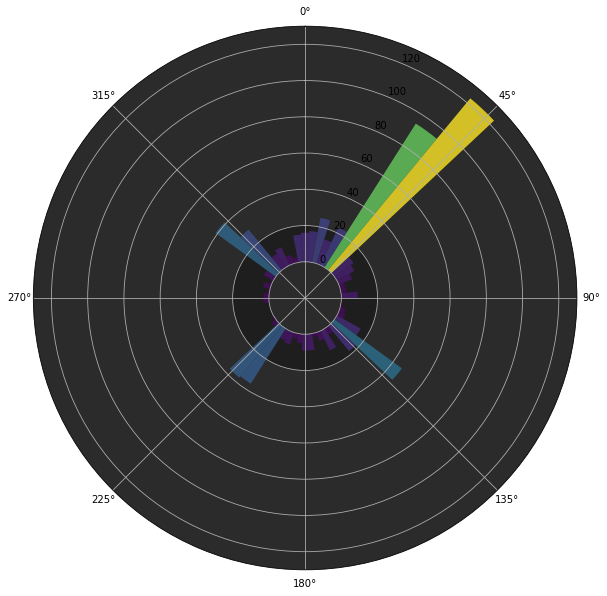

In [42]:
create_polar_chart(data, num_bins=50, level_filter=None)


#### GOAL
## fill the center portion of the plot to create a heat map of the field orientations



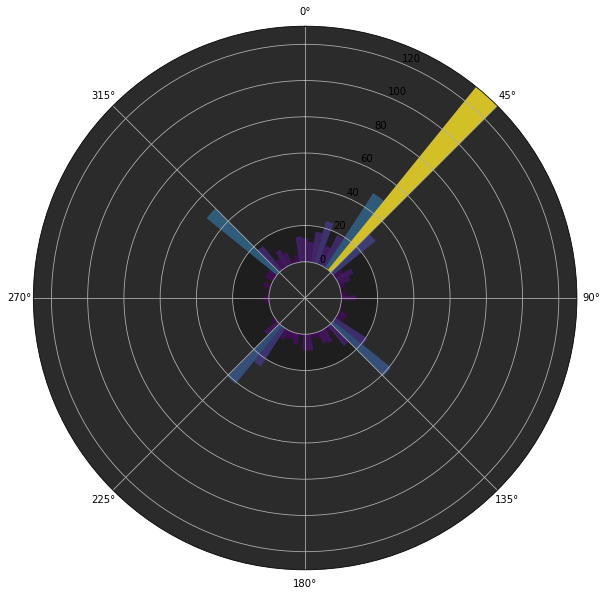

In [43]:
create_polar_chart(data, num_bins=60, level_filter=None)


In [44]:
# ### HEATMAP CODE

# import numpy as np
# import matplotlib.pyplot as plt

# def create_heatmap(data, num_bins=36, level_filter=None):
#     count_by_orientation = process_data(data, level_filter)

#     # Compute the histogram
#     bin_edges = np.linspace(0.0, 2 * np.pi, num_bins + 1)
#     bin_counts = np.zeros(num_bins)

#     for orientation, count in count_by_orientation.items():
#         idx = int(orientation / (360 / num_bins))
#         if idx == num_bins:
#             idx = 0
#         bin_counts[idx] += count

#     # Reshape histogram data into a 2D array
#     heatmap_data = np.tile(bin_counts, (num_bins, 1))

#     # Set plot size
#     plt.figure(figsize=(10, 10))

#     # Create heatmap
#     plt.imshow(heatmap_data, cmap='viridis', aspect='auto', interpolation='nearest', origin='lower')
#     plt.colorbar(label='Counts')

#     # Set x-axis ticks and labels
#     plt.xticks(np.arange(0, num_bins, num_bins // 6), np.arange(0, 361, 60))
#     plt.xlabel('Orientation (degrees)')

#     # Set y-axis ticks and labels (assuming equal radial divisions)
#     max_radius_label = 'Max Radius'
#     plt.yticks(np.arange(0, num_bins, num_bins // 6), [0, 1, 2, 3, 4, max_radius_label])
#     plt.ylabel('Radial Division')

#     plt.show()

# # Example usage:
# # create_heatmap(data)


In [45]:
# # Example usage:
# create_heatmap(data)

In [46]:
### Plot a histogram of the field orientations for all levels

import numpy as np
import matplotlib.pyplot as plt

def create_histogram(data, num_bins=36, level_filter=None):
    count_by_orientation = process_data(data, level_filter)
    
    # Compute the histogram
    bin_edges = np.linspace(0.0, 360.0, num_bins + 1)
    bin_counts = np.zeros(num_bins)
    
    for orientation, count in count_by_orientation.items():
        idx = int(orientation / (360 / num_bins))
        if idx == num_bins:
            idx = 0
        bin_counts[idx] += count
    
    bin_width = 360 / num_bins

    # Plot the histogram
    fig, ax = plt.subplots()
    ax.bar(bin_edges[:-1], bin_counts, width=bin_width, edgecolor='black')
    ax.set_xlabel('Field Orientation (degrees)')
    ax.set_ylabel('Number of Fields')
    ax.set_title('Field Orientation Histogram')

    # Set the major tick locations
    major_tick_locations = [45, 135, 225, 315]
    plt.xticks(major_tick_locations, major_tick_locations)


    
    plt.show()


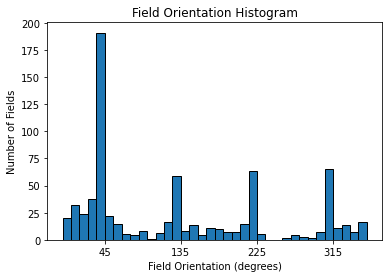

In [47]:
create_histogram(data, num_bins=36, level_filter=None)

END WORK BLOCK

In [48]:
df['field_cardinal_direction'].value_counts()

NE    279
SE    100
NW     96
SW     88
N      84
S      36
E      22
W      11
Name: field_cardinal_direction, dtype: int64

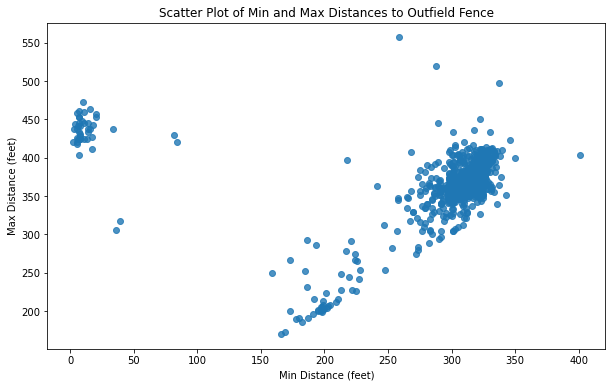

In [49]:
import matplotlib.pyplot as plt
# Rename the dataframe back to the default name
df = merged_df

# Set the plot size
plt.figure(figsize=(10, 6))

# Create the scatter plot
plt.scatter(df_cleaned['min_distance'], df_cleaned['max_distance'], alpha=0.8)

# Customize the plot
plt.xlabel('Min Distance (feet)')
plt.ylabel('Max Distance (feet)')
plt.title('Scatter Plot of Min and Max Distances to Outfield Fence')

# Display the plot in the Jupyter Notebook
plt.show()


In [50]:
##### CODE TO MAKE A LIST OF OUTLIERS #####

# Filter the DataFrame for fields with min distances below 100 feet
outliers = df[df['min_distance'] < 100]

# Display the outlier fields in the Jupyter Notebook
print(outliers[['park_name', 'min_distance', 'max_distance']])

# Save the outlier fields to a CSV file
outliers.to_csv('outlier_fields.csv', index=False)



                                park_name  min_distance  max_distance
97                              Manton HS            39           317
231   Adrian Lenawee Christian HS- replot            14           446
237               Ann Arbor Greenhills HS             8           424
238                  Ann Arbor Skyline HS             7           453
252                           Bellaire HS             4           444
253                      Benton Harbor HS            10           473
254                    Berrien Springs HS             8           442
262          Brooklyn Columbia Central HS            17           427
270                            Calumet HS            11           425
272                             Canton HS            20           453
276                       Central Lake HS             2           421
279                          Charlotte HS             6           442
289                 Croswell-Lexington HS             9           448
297                 

In [51]:
len(outliers)

43

In [52]:
df.head()

,park_name,foul,fop,level,home_plate,foul_area_sqft,fop_area_sqft,field_area_sqft,foul_area_per,fair_to_foul,...,country,school_id,school_name,students,division,Nickname,Color1,Color2,Color3,Color4
0,SW Christian HS Fort Worth - high school,"[(-97.4421601, 32.6418776), (-97.4431985, 32.6...","[(-97.4421601, 32.6418776), (-97.4421306000000...",High School,"(-97.4421601, 32.6418776)",21853.913745,99659.810373,121513.724118,0.179847,4.560273,...,United States,NaN,None,NaN,None,None,None,None,None,NaN
1,Soo High School,"[(-84.36583, 46.4813183), (-84.3658206, 46.482...","[(-84.36583, 46.4813183), (-84.3645398, 46.481...",High School,"(-84.36583, 46.4813183)",34451.384825,94783.943544,129235.328369,0.266579,2.751238,...,United States,NaN,None,NaN,None,None,None,None,None,NaN
2,Frankfort-Elberta Area HS,"[(-86.2258505, 44.6344082), (-86.2258357, 44.6...","[(-86.2258505, 44.6344082), (-86.2270454, 44.6...",High School,"(-86.2258505, 44.6344082)",25687.658559,86823.965374,112511.623933,0.228311,3.379988,...,United States,NaN,None,NaN,None,None,None,None,None,NaN
3,Ironwood HS,"[(-90.1514578, 46.457154), (-90.1505766, 46.45...","[(-90.1514578, 46.457154), (-90.15234150000002...",High School,"(-90.1514578, 46.457154)",37066.246977,95913.228498,132979.475475,0.278737,2.587616,...,United States,NaN,None,NaN,None,Red Devils,Red,White,NaN,NaN
4,Morenci HS,"[(-84.2069811, 41.7223814), (-84.2058371, 41.7...","[(-84.2069811, 41.7223814), (-84.2071112, 41.7...",High School,"(-84.2069811, 41.7223814)",35463.259931,92763.241003,128226.500934,0.276567,2.615756,...,United States,NaN,None,NaN,None,Bulldogs,Maroon,White,NaN,NaN


In [53]:
end_time = time.time()
total_time = end_time - start_time
print("Total time taken:", total_time, "seconds")
print("Total time taken:", total_time/60, "minutes")




Total time taken: 429.11829948425293 seconds
